In [2]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math

# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\core\_jit.py:29: UserWarning: Could not import numba package. All poliastro functions will work properly but the CPU intensive algorithms will be slow. Consider installing numba to boost performance.
  warnings.warn(


<ScienceState solar_system_ephemeris: 'jpl'>

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Starship DV is 9561.618214745116m/s
5671m/s of DV
departure on 2035-07-15 00:02:09.184
arrival on 2035-10-13 00:02:09.184


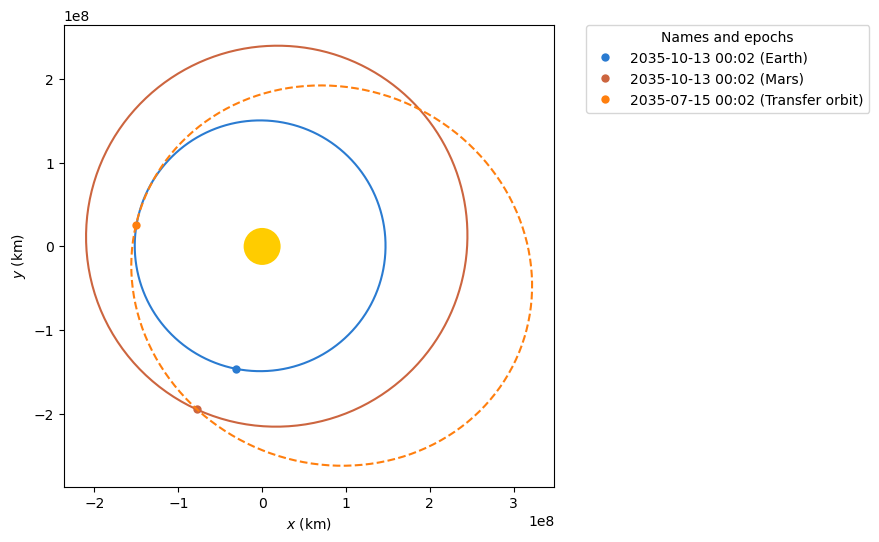

In [3]:
#starship specs
isp = 380
dry_mass = 100
prop_mass = 1200


#solve for a minimum ejection DV given a time period
transitTime = 90*u.day
resolution = 10*u.day
start_date = time.Time("2034-01-01 00:01", scale="utc").tdb
end_date = time.Time("2037-01-01 00:01", scale="utc").tdb

earth = Ephem.from_body(Earth, time_range(start_date, end=end_date+transitTime))
mars = Ephem.from_body(Mars, time_range(start_date, end=end_date+transitTime))

delta_time = end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
for i in range(int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = start_date+transitTime+i*resolution
    # Solve for departure and target orbits
    ss_earth = Orbit.from_ephem(Sun, mars, date_arrival)
    ss_mars = Orbit.from_ephem(Sun, earth, date_launch)
    # Solve for the transfer maneuver
    man_lambert = Maneuver.lambert(ss_mars, ss_earth)
    ejection = man_lambert[0]
    dv = np.linalg.norm(ejection[1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_launch
        lowest_orb,final = ss_mars.apply_maneuver(man_lambert, intermediate=True)

print(f"Starship DV is {isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)}m/s")   
print(f"{int(lowest_dv)}m/s of DV")
print(f"departure on {lowest_date}")
print(f"arrival on {lowest_date+transitTime}")
      

# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(Earth,  lowest_date+transitTime, label="Earth")
plotter.plot_body_orbit(Mars,  lowest_date+transitTime, label="Mars")

plotter.plot(lowest_orb, color="C1", label="Transfer orbit")

4.919720457330396 km2 / s2
-29.843687369317966 km2 / s2
Ejection DV is 5.896050188613422 km / s
6678 x 6678 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch 2035-07-15 00:02:09.184 (TDB)
6780 x -87801 km x 140.4 deg (GCRS) orbit around Earth (♁) at epoch 2035-07-15 00:02:09.184 (TDB)


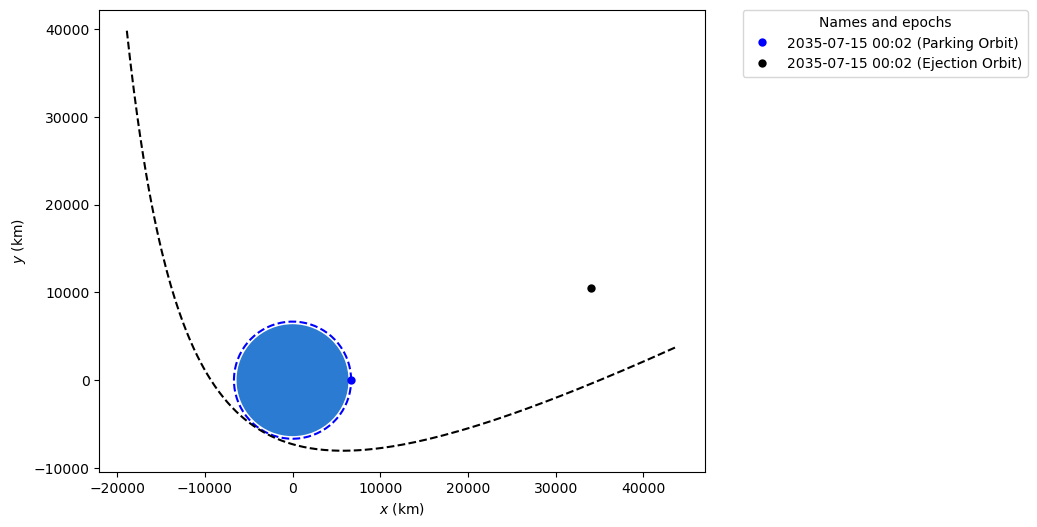

In [4]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)




#ejection from Earth
#calculate departure orbit
prop_time = 0.012*u.day

ss_leave = lowest_orb.propagate(prop_time)
r_earth,v_earth=ss_earth.r,ss_earth.v
r_traj_leave = ss_leave.r-r_earth
v_traj_leave = ss_leave.v-v_earth


ejection_orbit = Orbit.from_vectors(Earth,r_traj_leave,v_traj_leave,epoch = date_launch)
#ejection_orbit.inc = 0*u.rad
#propogate ejection_orbit to periapsis



parking_orbit = Orbit.circular(Earth,inc=0*u.rad, alt=300 << u.km,epoch = date_launch)



print(ejection_orbit.energy)# = 0*u.rad
print(parking_orbit.energy)

#calculate ejection DV
#print(parking_orbit.v)
dE = ejection_orbit.energy-parking_orbit.energy
dV=np.sqrt(dE)
print(f"Ejection DV is {dV}")


print(parking_orbit)
print(ejection_orbit)
earth_ejection_plotter = StaticOrbitPlotter()

ejection_orbit.inc = 0*u.rad
earth_ejection_plotter.plot(parking_orbit, label="Parking Orbit", color="b")
earth_ejection_plotter.plot(ejection_orbit, label="Ejection Orbit", color="k")